In [65]:
import pandas as pd
import numpy as np
import matplotlib as plt

# Data loading

In [66]:
path_to_data = 'datasets/raw/data/'

In [97]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))



# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]

list_of_df = [df.drop(columns=['changepoint']) for df in list_of_df]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

In [98]:
list_of_df[0].columns

Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly'],
      dtype='object')

In [99]:
# dataset characteristics printing
print('SKAB v0.9')
print(f'- A number of datasets: {len(list_of_df)}')
print(f'- Shape of the random dataset: {list_of_df[10].shape}')
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head(1))

SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1147, 9)
- A number of outliers (point anomalies): 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly
datetime,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0


# Data visualization

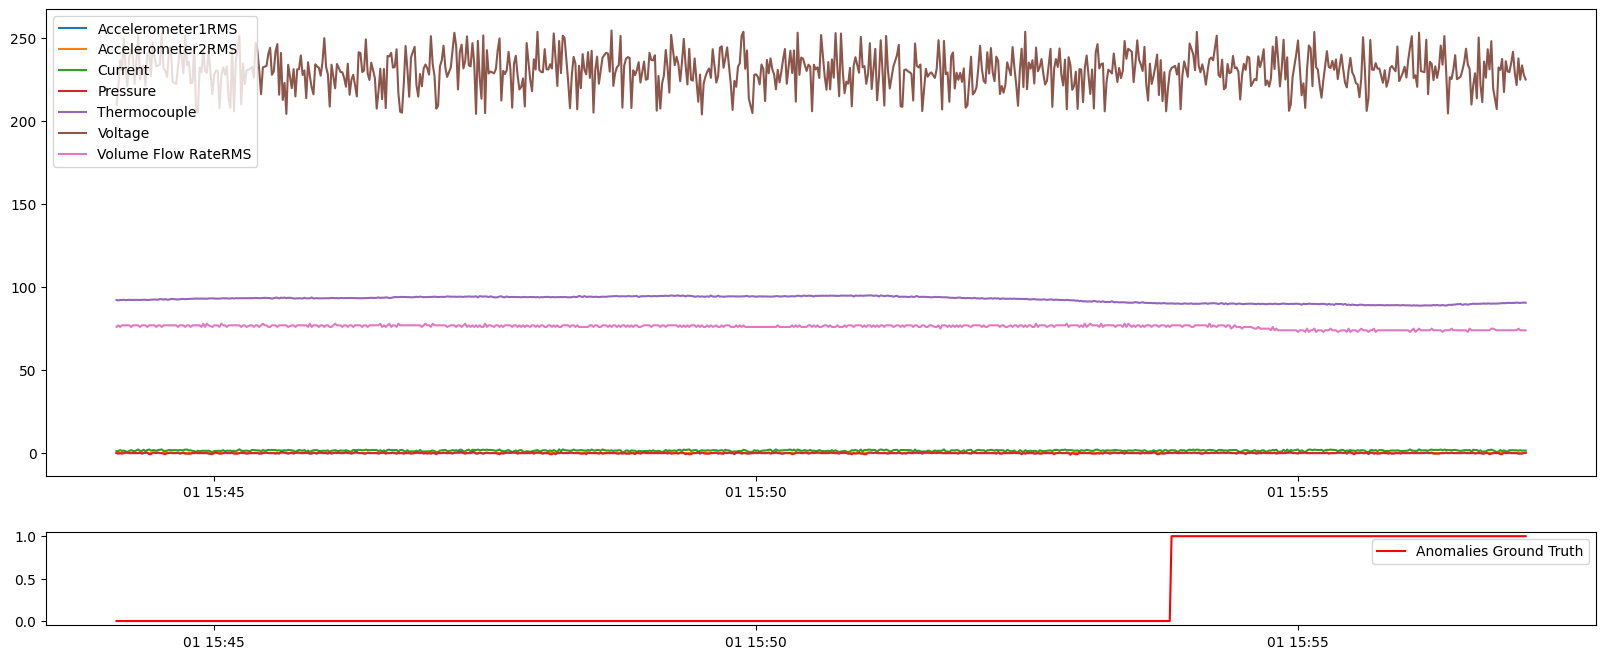

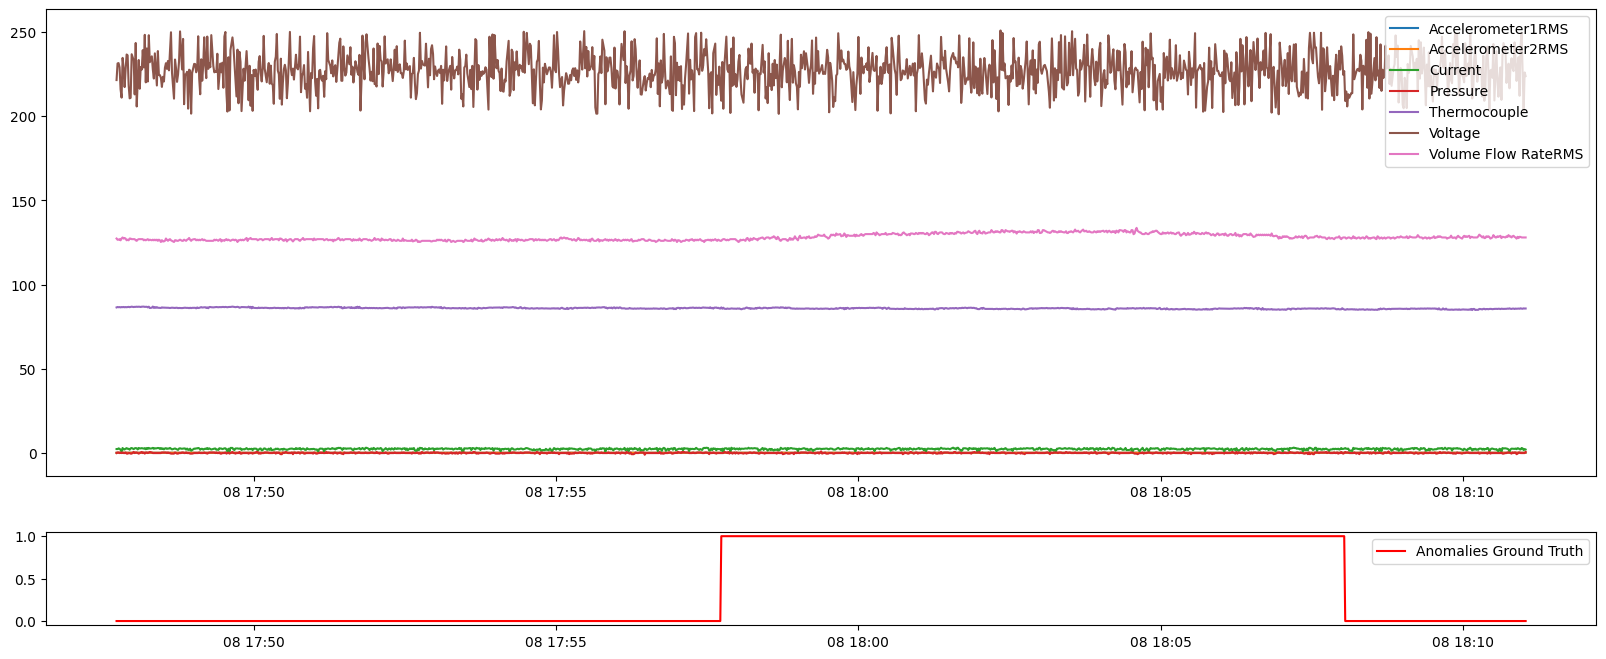

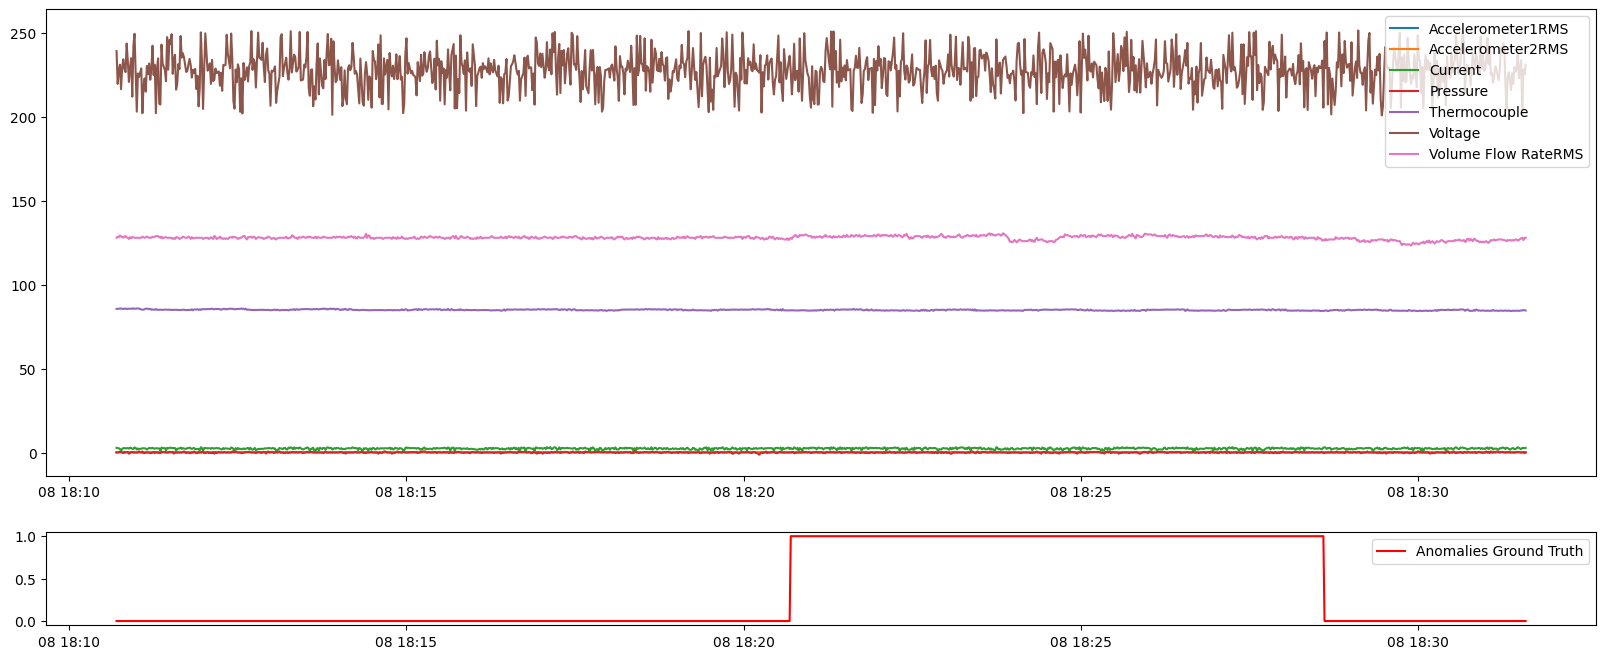

In [72]:
from plot_data import plot_skab

plot_skab(list_of_df[0].drop(columns=['anomaly']), list_of_df[0].anomaly)

plot_skab(list_of_df[1].drop(columns=['anomaly']), list_of_df[1].anomaly)

plot_skab(list_of_df[2].drop(columns=['anomaly']), list_of_df[2].anomaly)

# HMM anomaly detection

In [77]:
from hmmlearn import hmm


class HMM(hmm.GaussianHMM):
    def __init__(self, back_step, *args, **kwargs):
        self.threshold = 0
        self.back_step = back_step
        self.test_abnormality = None
        self.train_abnormality = None
        super(HMM, self).__init__(*args, **kwargs)

    def train(self, train_data: pd.DataFrame, fit_num: int, *args, **kwargs):
        X = train_data.values.reshape(-1, 1)
        lengths = [len(train_data)] * train_data.shape[1]
        for i in range(fit_num):
            self.fit(X, lengths)
        log_prob = self.calculate_log_prob(train_data)
        self.train_abnormality = self.calculate_abnormality(log_prob)
        self.threshold = self.calculate_threshold(self.train_abnormality)

    def analise(self, test_data: pd.DataFrame, *args, **kwargs) -> np.array:
        log_prob = self.calculate_log_prob(test_data)
        self.test_abnormality = self.calculate_abnormality(log_prob)
        return np.array(self.test_abnormality > self.threshold).astype(int)

    def calculate_log_prob(self, data: pd.DataFrame, *args, **kwargs) -> np.array:
        log_prob = np.array([self.score(data.values[0:i + 1].reshape(-1, 1)) if i < self.back_step
                            else self.score(data.values[i - self.back_step:i + 1].reshape(-1, 1))
                            for i in range(len(data.values))])
        return log_prob

    @staticmethod
    def calculate_abnormality(log_prob: np.array) -> np.array:
        return -np.append(log_prob[0], np.diff(log_prob))

    @staticmethod
    def calculate_threshold(abnormality: np.array) -> np.array:
        ratio = 0.005  # Percentage of judgments as abnormal
        return np.sort(abnormality)[int((1 - ratio) * len(abnormality))]

In [86]:
detector = HMM(n_components=15, covariance_type="full", back_step=100)

df = list_of_df[1]
detector.train(df[:400].drop(columns='anomaly'), 10)
anomalies = detector.analise(df.drop(columns=['anomaly']))

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


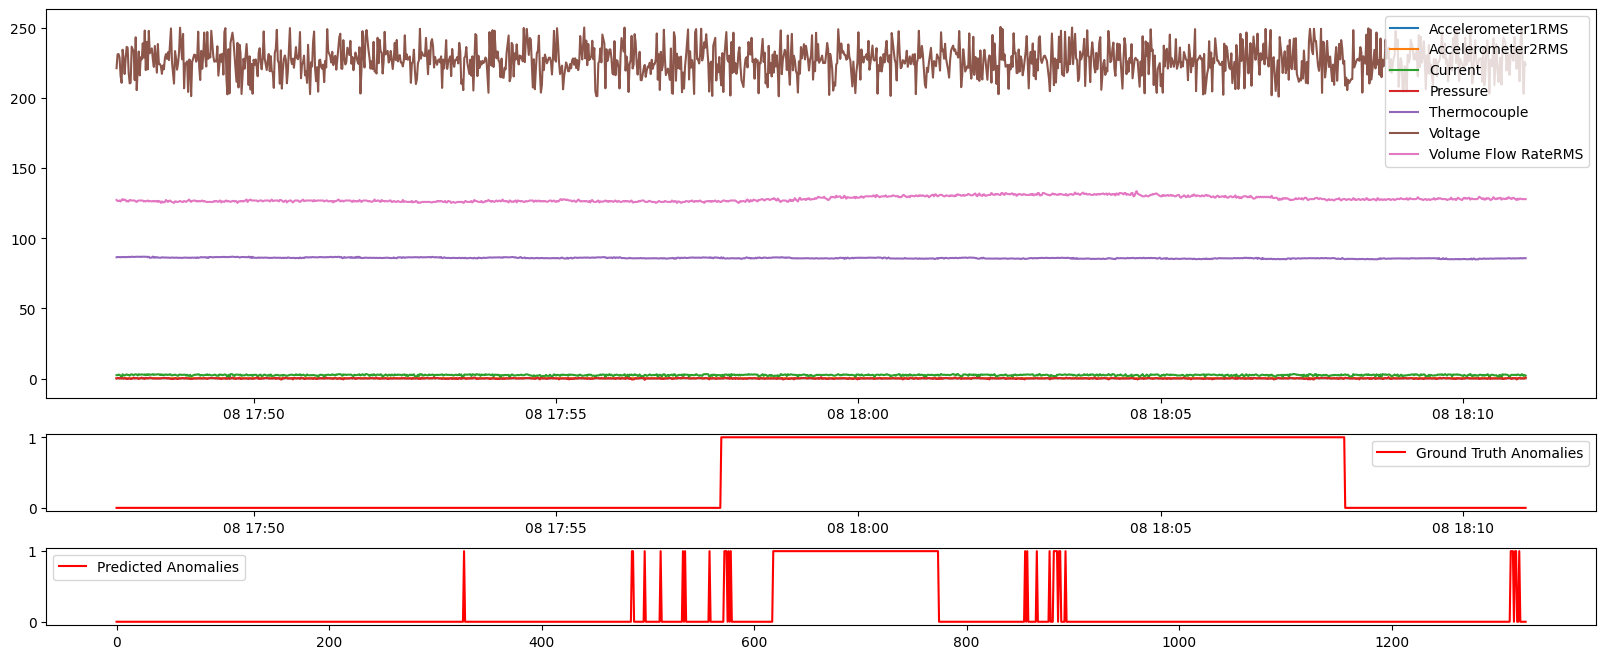

In [87]:
plot_skab(list_of_df[1].drop(columns=['anomaly']), list_of_df[1].anomaly, anomalies)

In [88]:
df = list_of_df[10]
anomalies = detector.analise(df.drop(columns=['anomaly']))

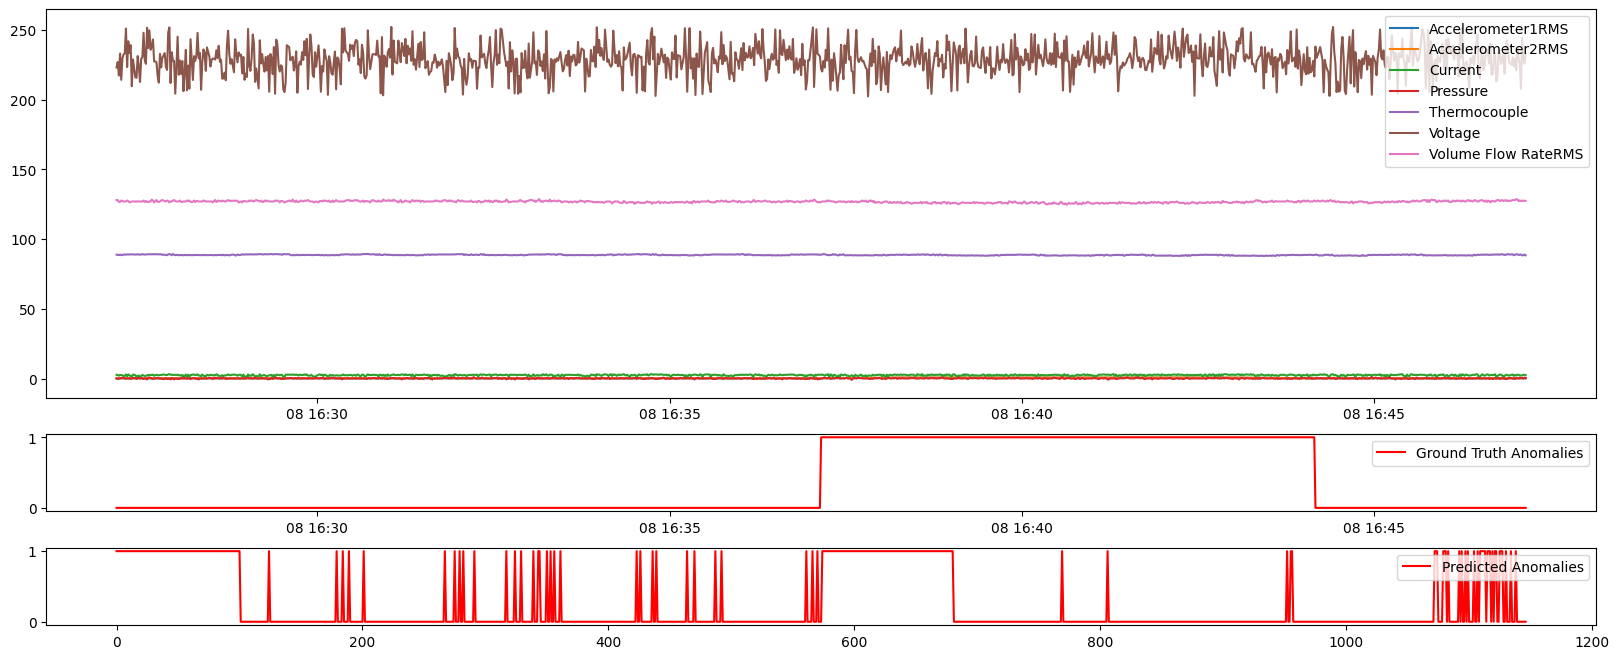

In [89]:
plot_skab(list_of_df[10].drop(columns=['anomaly']), list_of_df[10].anomaly, anomalies)

In [90]:
from hmmlearn import hmm
from tqdm import tqdm

class HMM:
    def __init__(self, n_states, n_fits, time_step):
        self.n_states = n_states
        self.best_model = None
        self.n_fits = n_fits
        self.time_step = time_step
        self.test_abnormality = None
        self.train_abnormality = None

    def train(self, train_data):
        X = train_data.values.reshape(-1, 1)
        lengths = [len(train_data)] * train_data.shape[1]

        best_score = None
        model = None

        for i in range(self.n_fits):
            model = hmm.GaussianHMM(n_components=self.n_states, covariance_type='full', random_state=i)
            try:
                model.fit(X, lengths)
            except:
                # sometimes the algorithm is not able to converge
                print('Failure to fit')
                continue
            score = model.score(X)
            print(f'Model #{i}\tScore: {score}')
            if best_score is None or (score > best_score and score > 0):
                self.best_model = model
                best_score = score
        log_prob = self.calculate_log_prob(train_data)
        self.train_abnormality = self.calculate_abnormality(log_prob)
        self.threshold = self.calculate_threshold(self.train_abnormality)

    def calculate_log_prob(self, data: pd.DataFrame, *args, **kwargs) -> np.array:
        log_prob = np.array([self.best_model.score(data.values[0:i + 1].reshape(-1, 1)) if i < self.time_step
                            else self.best_model.score(data.values[i - self.time_step:i + 1].reshape(-1, 1))
                            for i in range(len(data.values))])
        return log_prob

    @staticmethod
    def calculate_abnormality(log_prob: np.array) -> np.array:
        return -np.append(log_prob[0], np.diff(log_prob))

    @staticmethod
    def calculate_threshold(abnormality: np.array) -> np.array:
        ratio = 0.005  # Percentage of judgments as abnormal
        return np.sort(abnormality)[int((1 - ratio) * len(abnormality))]

    def detect_anomalies(self, test_data):
        log_prob = self.calculate_log_prob(test_data)
        self.test_abnormality = self.calculate_abnormality(log_prob)
        return np.array(self.test_abnormality > self.threshold).astype(int)

In [92]:
detector = HMM(n_states=15, n_fits=20, time_step=120)

df = list_of_df[1]
detector.train(df[:400].drop(columns='anomaly'))

anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']))

Model #0	Score: -639.3638261229536
Model #1	Score: -533.2755507250439
Model #2	Score: -639.372410760944
Model #3	Score: -236.33018909073436
Model #4	Score: 1383.349133726328
Model #5	Score: -4779.987487237517
Model #6	Score: 1378.1623160433414
Model #7	Score: -1921.3544879665278
Model #8	Score: -4782.643055347172
Model #9	Score: -395.0118881260165
Model #10	Score: -632.8261012147192
Model #11	Score: -504.5484509098787
Model #12	Score: -532.7848683580369
Model #13	Score: -2747.7236108915527
Model #14	Score: -1663.618835524485
Model #15	Score: -5234.977248871999
Model #16	Score: -1864.7154249662979
Model #17	Score: -639.3711025359388
Model #18	Score: -503.7241010088324
Model #19	Score: 1380.9473991522873


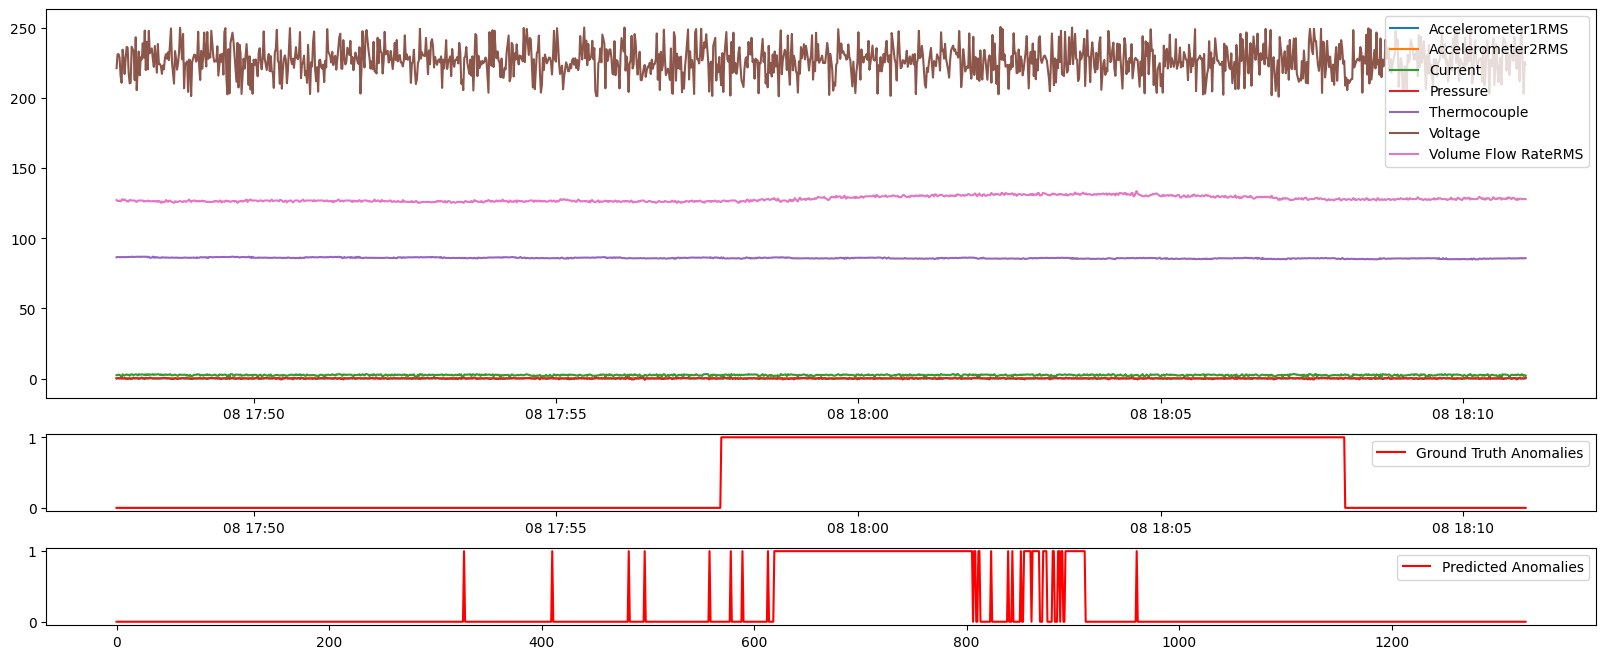

In [93]:
plot_skab(list_of_df[1].drop(columns=['anomaly']), list_of_df[1].anomaly, anomalies)

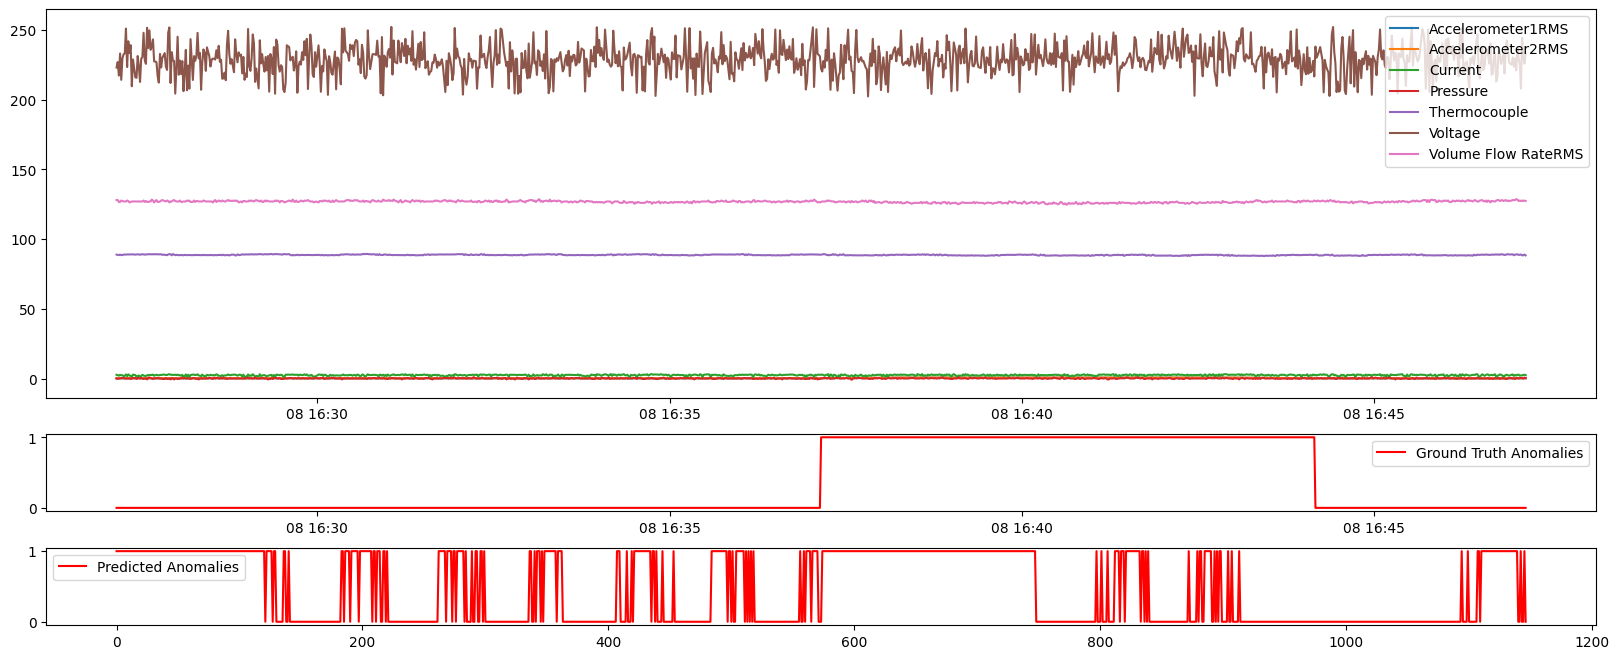

In [94]:
df = list_of_df[10]
anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']))
plot_skab(list_of_df[10].drop(columns=['anomaly']), list_of_df[10].anomaly, anomalies)

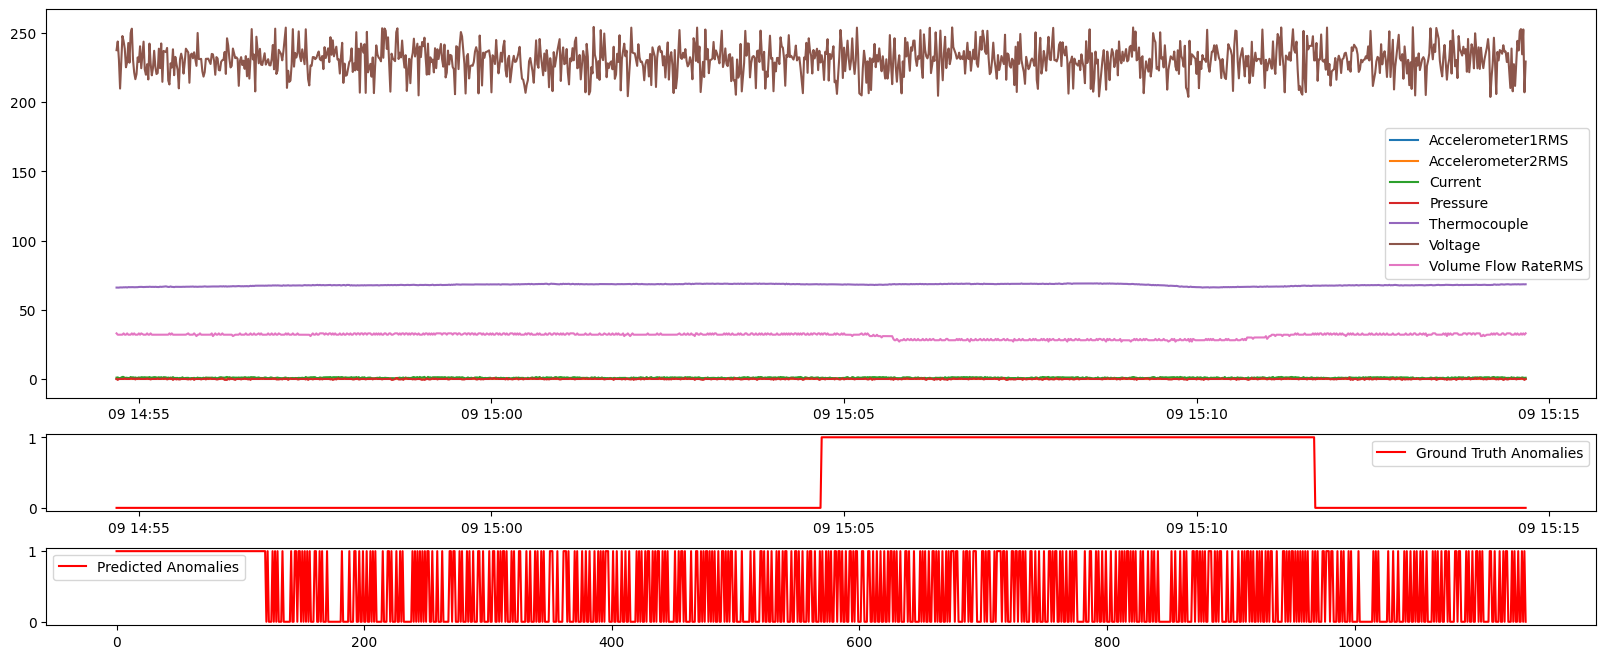

In [95]:
df = list_of_df[20]
anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']))
plot_skab(list_of_df[20].drop(columns=['anomaly']), list_of_df[20].anomaly, anomalies)

Model #0	Score: 1584.623796042189
Model #1	Score: 157.3974529065149
Model #2	Score: 158.54852962301172
Model #3	Score: 1014.7623278231076
Model #4	Score: 144.00257903633235
Model #5	Score: 158.40293967585268
Model #6	Score: 2184.907257905163
Model #7	Score: 2177.777855836982
Model #8	Score: -644.9411829557432
Model #9	Score: 2193.3682317724565
Model #10	Score: -678.7414821834401
Model #11	Score: 1014.8146524013979
Model #12	Score: -471.4460615486658
Model #13	Score: -95.65158797607404
Model #14	Score: 1061.4125131888177
Model #15	Score: 1062.7328803770474
Model #16	Score: -3100.1242686066857
Model #17	Score: 2177.851640833205
Model #18	Score: 161.91315066540102
Model #19	Score: 1578.938783918221


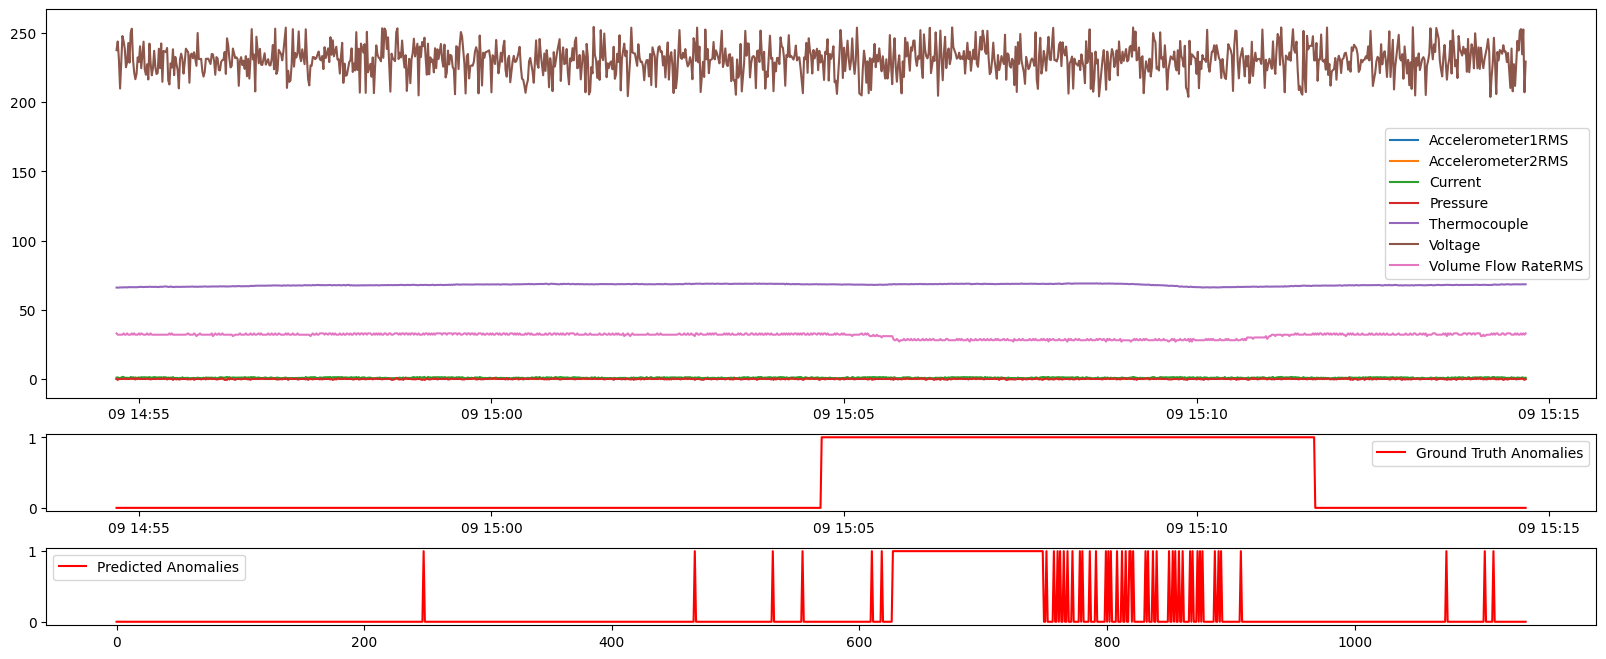

In [96]:
detector = HMM(n_states=15, n_fits=20, time_step=120)

df = list_of_df[20]
detector.train(df[:400].drop(columns='anomaly'))

anomalies = detector.detect_anomalies(df.drop(columns=['anomaly']))

plot_skab(list_of_df[20].drop(columns=['anomaly']), list_of_df[20].anomaly, anomalies)